# Assignment 02     
## CSCI E-108
### Luciano Carvalho


In this assignment you will work with some basic streaming analytic algorithms. To avoid the complexities of installing and setting up a real streaming analytics platform, you will work with stream flow data loaded from local files. Specifically in this assignment you will:    
1. Create and apply code to perform basic stream queries.    
2. Using stream queries and plots, explore the stream data.    
3. Use moving windows to compute moving averages and sub-sample a stream.    
4. Use exponential decay filters to compute moving averages and sub-sample a stream.    
5. Work with a Bloom and quotient filters to filter for customer identifiers on a list.
6. Use the count-min-sketch algorithm to find counts of unique event identifiers.
7. Use the HyperLogLog algorithm to find the cardinality of events in a stream.  

## Overview

The United States Geological Survey (USGS) maintains over 13,500 stream flow gages in the United States. Measurements from most of these gages are recoded every 15 min and uploaded every 4 hours are [available for download](https://waterdata.usgs.gov/nwis/rt). Stream flow data are used as inputs for complex water management tasks for purposes such as agriculture, residential use and conservation. For this assignment you will work with the time series of measurements for two stream flow gages on tributaries of the the Columbia River in the US State of Washington.     

To get started, execute the code in the cell below to import the packages you will need.

> **Note:** You will need to pip install four packages to run the code in this notebook. You can perform the installation of these packages by uncommenting the shell commands shown in the cell below. Alternatively, you can also Conda install these packages.    
> 1. [Mmh3](https://github.com/hajimes/mmh3)      
> 2. [Bitarray](https://github.com/ilanschnell/bitarray)
> 3. [PyProbables](https://pyprobables.readthedocs.io/en/latest/index.html)
> 4. [Datasketch](https://ekzhu.com/datasketch/index.html)

In [7]:
!pip install mmh3
!pip install bitarray
!pip install pyprobables
!pip install datasketch

  Using cached pyprobables-0.6.0-py3-none-any.whl (40 kB)


In [8]:
import pandas as pd
import numpy as np
import numpy.random as nr
import mmh3
from bitarray import bitarray
from probables import QuotientFilter, CountMinSketch, HeavyHitters
from datasketch import HyperLogLog
import math
import matplotlib.pyplot as plt
from decimal import Decimal

%matplotlib inline

## Loading the Dataset  

The next step is to load the stream gage data. The code in the cell below loads the time series data for the first gage. This gage is sited on the Okanogan river.  

The code in the cell below does the following:  
1. Loads the data from a .csv file.
2. Converts the time stamp column to an index of the Pandas data frame.
3. Assigns human-understandable names to the columns.  
4. Returns just the first 4 columns of the data frame.

Execute this code and examine the results.

In [9]:
def read_index_series(file_name):
    '''Function to read time series data from a file.
    Argument is the path and filename.'''
    df = pd.read_csv(file_name, sep='\t')
    df.index = df.datetime
    df.drop('datetime', axis=1, inplace=True)
    df = df.iloc[:,:4]
    df.columns = ['Agency', 'Site_number', 'Time_zone', 'Stream_flow']
    return df.iloc[:,:4]

Malott = read_index_series('../data/12447200_Okanogan_at_Malott.txt')
Malott

,Agency,Site_number,Time_zone,Stream_flow
datetime,,,,
2020-03-01 00:00,USGS,12447200,PST,2050
2020-03-01 00:15,USGS,12447200,PST,2050
2020-03-01 00:30,USGS,12447200,PST,2050
2020-03-01 00:45,USGS,12447200,PST,2050
2020-03-01 01:00,USGS,12447200,PST,2050
...,...,...,...,...
2020-08-31 22:45,USGS,12447200,PDT,1350
2020-08-31 23:00,USGS,12447200,PDT,1350
2020-08-31 23:15,USGS,12447200,PDT,1350


The other time series is for a gage on the Yakima River. Execute the code in the cell below and examine the result.

In [10]:
CleElm = read_index_series('../data/12479500_Yakima_At_CleElm.txt')
CleElm

,Agency,Site_number,Time_zone,Stream_flow
datetime,,,,
2020-03-01 00:00,USGS,12484500,PST,1620
2020-03-01 00:15,USGS,12484500,PST,1620
2020-03-01 00:30,USGS,12484500,PST,1620
2020-03-01 00:45,USGS,12484500,PST,1620
2020-03-01 01:00,USGS,12484500,PST,1620
...,...,...,...,...
2020-08-31 22:45,USGS,12484500,PDT,3140
2020-08-31 23:00,USGS,12484500,PDT,3140
2020-08-31 23:15,USGS,12484500,PDT,3140


Since we really only want to work with one data frame. The code in the cell below merges the two time series and sorts them into time index order. Execute this code and examine the result, paying attention to the site number and the datetime index.  

In [11]:
stream_flow = pd.concat([Malott,CleElm]).sort_index()
stream_flow

,Agency,Site_number,Time_zone,Stream_flow
datetime,,,,
2020-03-01 00:00,USGS,12447200,PST,2050
2020-03-01 00:00,USGS,12484500,PST,1620
2020-03-01 00:15,USGS,12484500,PST,1620
2020-03-01 00:15,USGS,12447200,PST,2050
2020-03-01 00:30,USGS,12447200,PST,2050
...,...,...,...,...
2020-08-31 23:15,USGS,12447200,PDT,1350
2020-08-31 23:30,USGS,12484500,PDT,3140
2020-08-31 23:30,USGS,12447200,PDT,1350


## Querying Stream Data

Common stream data operations are often formulated as queries on the stream data. Many streaming data platforms use extensions of SQL for these queries.   

To keep things simple in this assignment we will just use a basic query function. The function shown in the cell below supports queries on the time series.      

In [12]:
def query_stream(df, Columns=None, site_numbers=None, start_time=None, end_time=None):
    '''
    Function to query the stream gage time series data. The arguments are:
    df = the data frame containing the data.
    Columns = a list of columns to return.
    site_numbers = a list of gage site numbers to query data.
    start_time = the start time of the returned data as datatime string or integer index.
    end_time = the end time of the returned data as datatime string or integer index.
    '''
    ## First set values for arguments set to Null
    if Columns==None: Columns = df.columns
    if start_time==None: start_time = df.index[0]
    if end_time==None: end_time = df.index[df.shape[0]-1]
    if site_numbers==None: site_numbers = df.Site_number.unique()

    ## Select the sites
    df = df.loc[df.Site_number.isin(site_numbers), Columns]

    ## Test if index is a string datetime or an integer
    ## use iloc method if an integer.
    ## A slice over the time range is created based on the index type.
    if isinstance(df,pd.DataFrame):
        if isinstance(start_time, str):
            df = df.loc[start_time:end_time,:]
        else:
            df = df.iloc[start_time:end_time,:]
    else: # Must be a Pandas series
        if isinstance(start_time, str):
            df = df.loc[start_time:end_time]
        else:
            df = df.iloc[start_time:end_time]
    ## Return the results of the query
    return df

You can see the options to run `query_stream` function by executing the code in the cell below.

In [13]:
print(query_stream.__doc__)


    Function to query the stream gage time series data. The arguments are:
    df = the data frame containing the data.
    Columns = a list of columns to return.
    site_numbers = a list of gage site numbers to query data.
    start_time = the start time of the returned data as datatime string or integer index.
    end_time = the end time of the returned data as datatime string or integer index.
    


An example of using the query function is shown in the cell below. Execute this code and examine the result.

In [14]:
len(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]))

17660

> **Exercise 02-01:** Using the `query_stream` function, write and execute the code in the cell below to compute and display the mean `Stream_flow`for the month of April of 2020 of site 12484500. Use the [Pandas.DataFrame.mean](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) method to compute the mean. Notice that using this approach we can compute most any statistic of interest on the query result.    

In [15]:
# Create April 2020 stream for site 12484500
april_2020_stream = query_stream(stream_flow, Columns=['Stream_flow'], site_numbers=[12484500], start_time='2020-04-01', end_time='2020-04-30')
april_2020_stream

,Stream_flow
datetime,
2020-04-01 00:00,1460
2020-04-01 00:15,1460
2020-04-01 00:30,1460
2020-04-01 00:45,1460
2020-04-01 01:00,1460
...,...
2020-04-29 22:45,2700
2020-04-29 23:00,2700
2020-04-29 23:15,2690


In [16]:
# Compute the mean Stream_flow for April 2020 for site 12484500
mean_stream_flow = april_2020_stream['Stream_flow'].mean()

# Display the mean Stream_flow
mean_stream_flow

2229.8347701149423

## Plotting Streaming Data

Visualization is important tool in data exploration and discovery. Numerical stream data is ideal for visual exploration if it can be subsampled to manageable size.  

The function in the cell below creates a time series plot. The time index of the Pandas data frame is used to generate the x-axis values. Execute the code in this cell to load this function.

In [17]:
def plot_time_series(df, ax=None, ylabel='Stream flow', title=''):
    if ax==None: fig, ax = plt.subplots(figsize=(20, 6))
    df.plot(ax=ax);
    ax.set_xlabel('Date');
    ax.set_ylabel(ylabel);
    ax.set_title(title)
    plt.show()
    return ax

The code in the cell below creates time series plots of the stream flow data. The flow time series for two stream gages queried as arguments to the plot function. Execute this code and examine the results.

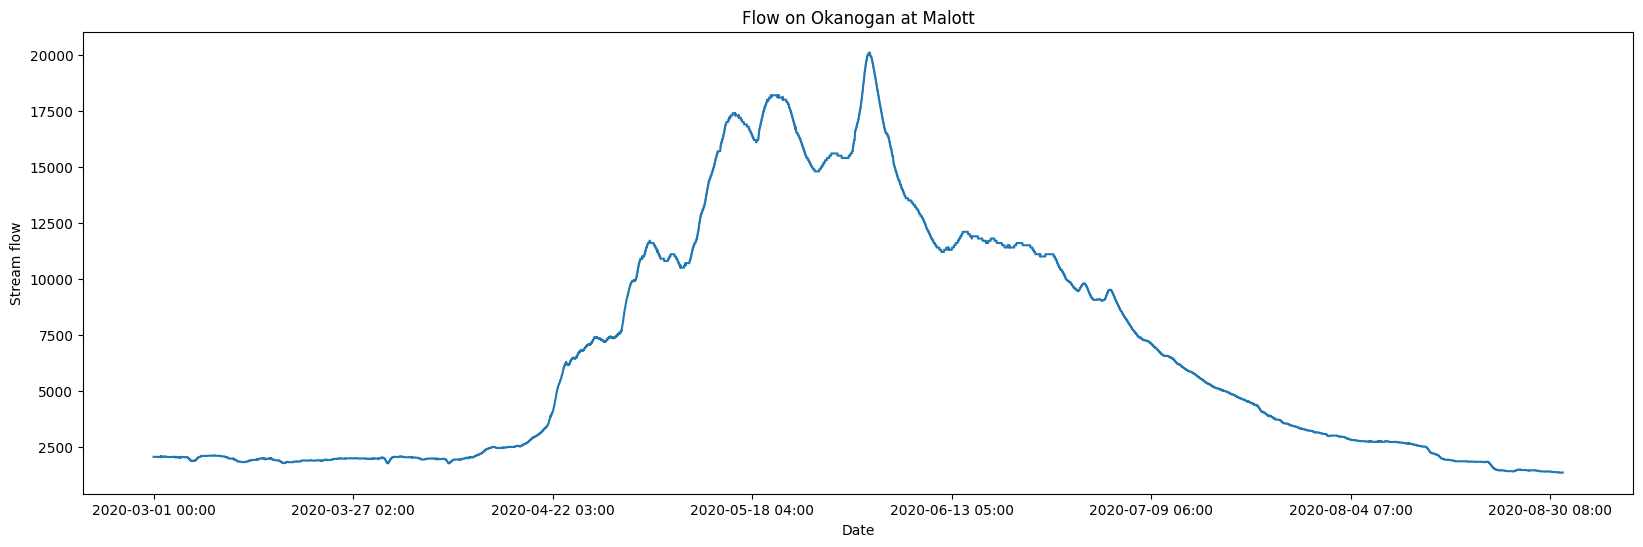

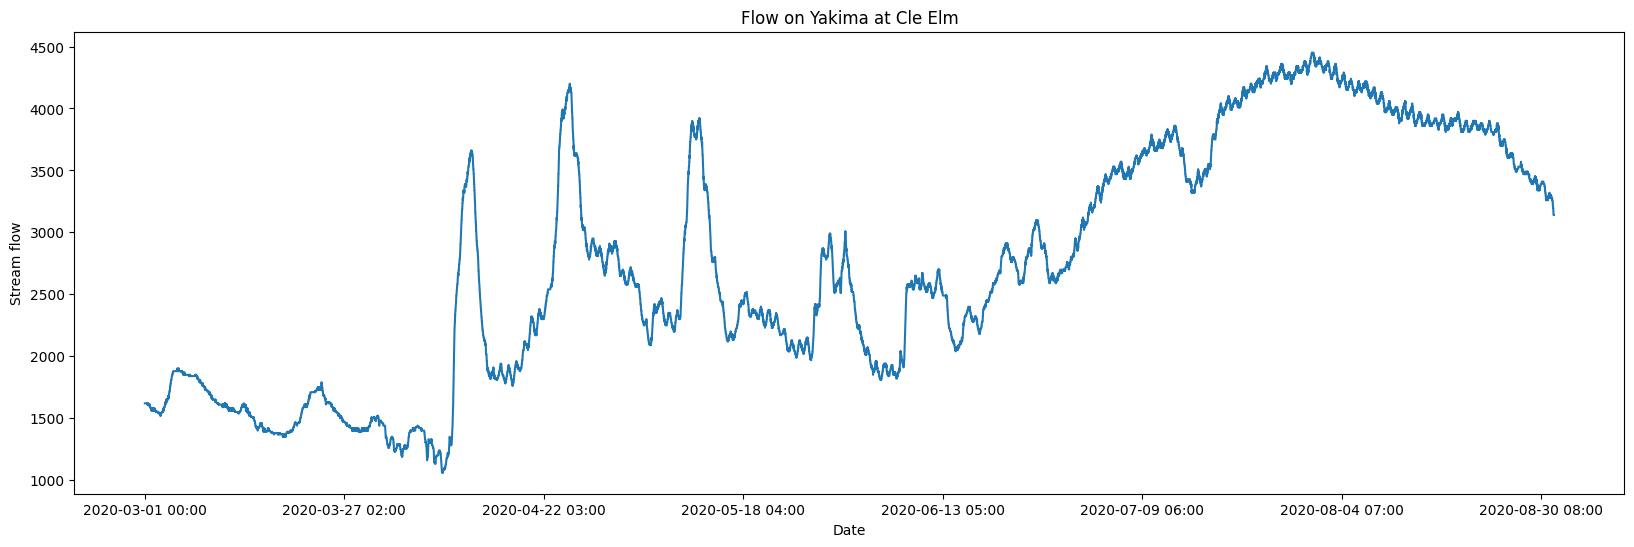

In [18]:
_=plot_time_series(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12447200]), title='Flow on Okanogan at Malott')
_=plot_time_series(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]), title='Flow on Yakima at Cle Elm')

The time series of stream flow at both of these gages is rather complex. Both rivers have several dams used to control the flow. The flow is optimized to conserve fisheries and to supply agriculture in the Columbia River Basin. Water in reservoirs accumulates in the spring as mountain snow melts. The water is then released throughout the spring and summer.

But, what can we make of the noticeable spikes in flow, particularly for gage $12484500$ on the Yakima River. Even with the control provided by dams and reservoirs spring and early summer storm events can cause temporary increases in water flow. These storms bring heavy, and often warm, rain. Flow in the rivers increases not only because of the rainfall, but also since warm rain accelerates snow melt in the higher elevations.   

> **Exercise 02-02:** The transitory flow events on the Yakima River warrant some further investigation. You now have the tools to query and plot the stream flow time series. Your goal is to determine if there are common properties (e.g. duration or amplitude) of these events. Plot the results of a query for stream flows on gage $12484500$, Yakima River, from the 6th day of April to the 20th day of June, 2020.

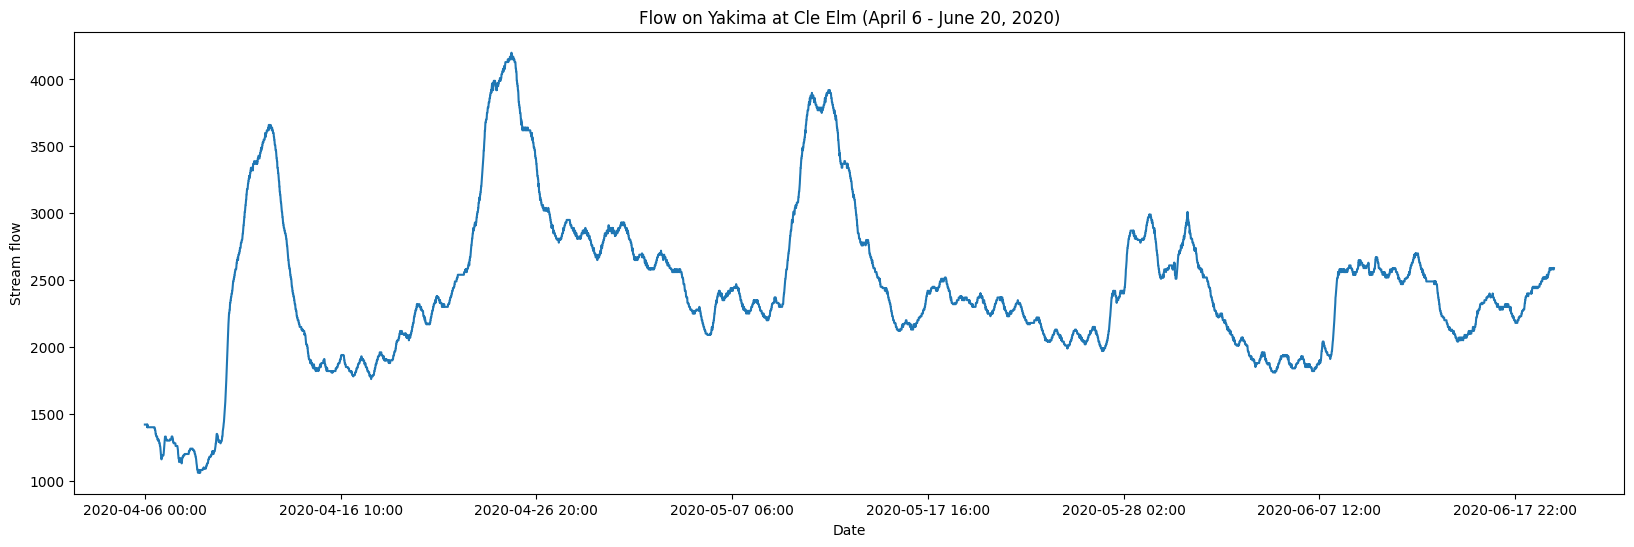

In [19]:
# Query and plot the stream flow data for the specified date range
yakima_april_june_2020 = query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500], start_time='2020-04-06', end_time='2020-06-20')
_=plot_time_series(yakima_april_june_2020, title='Flow on Yakima at Cle Elm (April 6 - June 20, 2020)')

> Discuss any common pattern in terms of approximately common high amplitudes or durations of these flow events you can see. Note, this question is a bit open ended.      

> **Answer:** These flow events typically have high amplitudes between 3,500 and 4,500 units and durations ranging from 10 to 15 days. The rapid rise and slower decline pattern are consistent throughout, indicating common environmental factors such as rainstorms or snowmelt influencing the river's flow.

## Applying Moving Window Filters

Moving window filters are a commonly used method to compute statistical samples from streaming data.

Apply a moving window filter.

> **Exercise 02-03:** You will complete and test the function in the cell below. The function queries a time series to create overlapping windows of a specified length and stride. For each window the mean of the stream flow is computed. The function returns a [Pandas Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) object. The time index of the Series object is the mid-point index of the window used to compute the statistic.
> 1. Use a `for` loop to create the overlapping moving window samples of the input. The window will use the `length` and `stride` arguments to the function. At each iteration, the window will advance by `stride` time steps. See the [tutorial on the Python range function](https://www.w3schools.com/python/ref_func_range.asp) for help.    
>   - Query the input stream data for the stream flow values in the window. The `query_stream` function accepts integer indices for the `start_time` and `end_time` arguments. Make sure the these indicies are within the range of the original time series.  
>   - Append the mean of the stream flow values in the window to the `out` list.    
>   - Append the difference between the sample at index `half_length` and the sample mean to the `difference` list.     
>   - Append the time index of the midpoint of the window to the `idx` list.  
> 2. Once the loop has terminated, use the [Pandas.Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) constructor to instantiate the return series of both the mean filtered list and the differences list. Use the `idx` list as the idex for each of these series.   
> 3. Return both the moving average series and the difference series.      

In [20]:
def window_average(ts, length=16, stride=8, Columns='Stream_flow', site_numbers=[12484500]):
    half_length = int(length / 2) - 1
    idx = []
    out = []
    difference = []

    # Get the stream flow data for the specified site
    stream_data = query_stream(ts, Columns=[Columns], site_numbers=site_numbers)

    # Debugging: Print the columns of the DataFrame or Series
    if isinstance(stream_data, pd.DataFrame):
        print("Columns in the DataFrame:", stream_data.columns)
    else:
        print("Returned object is not a DataFrame. It is a:", type(stream_data))

    # Check if the specified column exists in the DataFrame
    if Columns not in stream_data.columns:
        raise KeyError(f"Column '{Columns}' not found in the DataFrame.")

    # 1. Use a for loop to create the overlapping moving window samples of the input.
    for start in range(0, len(stream_data) - length + 1, stride):
        end = start + length

        # Query the input stream data for the stream flow values in the window.
        window = stream_data.iloc[start:end]

        # Append the mean of the stream flow values in the window to the out list.
        window_mean = window[Columns].mean()
        out.append(window_mean)

        # Append the difference between the sample at index half_length and the sample mean to the difference list.
        midpoint = start + half_length
        difference.append(window.iloc[half_length][Columns] - window_mean)

        # Append the time index of the midpoint of the window to the idx list.
        idx.append(window.index[half_length])

    # 2. Use the Pandas.Series constructor to instantiate the return series of both the mean filtered list and the differences list.
    # Use the idx list as the index for each of these series.
    out_series = pd.Series(out, index=idx)
    difference_series = pd.Series(difference, index=idx)

    # 3. Return both the moving average series and the difference series.
    return out_series, difference_series

Yakima = query_stream(stream_flow, site_numbers=[12484500])

filtered_12, Yakima_difference_12 = window_average(Yakima)

# Display the results
filtered_12.head(), Yakima_difference_12.head()


Columns in the DataFrame: Index(['Stream_flow'], dtype='object')


(2020-03-01 01:45    1620.000
 2020-03-01 03:45    1620.000
 2020-03-01 05:45    1620.000
 2020-03-01 07:45    1615.625
 2020-03-01 09:45    1611.250
 dtype: float64,
 2020-03-01 01:45    0.000
 2020-03-01 03:45    0.000
 2020-03-01 05:45    0.000
 2020-03-01 07:45    4.375
 2020-03-01 09:45   -1.250
 dtype: float64)

> 4. Next you will test your function by completing and executing the code in the cell below. Use your `window_average` function to create a Pandas Series with 4-hour stream flow averages (length of 16 time steps), taken every 2 hours (stride of 8 time steps). Name your return Series `filtered_12 and difference series `Yakima_difference_12`. Compute and print the length of the mean filtered series. The code provided queries the data so that you are working with only values from the Yakima River gage. Using flow rate values from only one gage simplifies the bookkeeping for window sampling.

In [21]:
## Query to create a series with only the Yakima River stream gage data.
Yakima = query_stream(stream_flow, site_numbers=[12484500])

filtered_12, Yakima_difference_12 = window_average(Yakima)
len(filtered_12)

Columns in the DataFrame: Index(['Stream_flow'], dtype='object')


2206

> Notice how the length of the time series has been significantly reduced. Is the reduction in length of the time series consistent with a stride of 8 time steps?   
> **End of Exercise.**

In [22]:
# Original length of the Yakima DataFrame
original_length = len(Yakima)
print("Original length of Yakima DataFrame:", original_length)

# Calculate the expected new length
window_length = 16
stride = 8
expected_new_length = (original_length - window_length) // stride + 1
print("Expected new length:", expected_new_length)

# Query to create a series with only the Yakima River stream gage data
Yakima = query_stream(stream_flow, site_numbers=[12484500])

# Apply the window average function
filtered_12, Yakima_difference_12 = window_average(Yakima, length=window_length, stride=stride)

# Print the actual length of the filtered series
actual_new_length = len(filtered_12)
print("Actual new length:", actual_new_length)

# Check if the reduction in length is consistent with the stride of 8 time steps
is_consistent = actual_new_length == expected_new_length
print("Is the reduction in length consistent with a stride of 8 time steps?", is_consistent)


Original length of Yakima DataFrame: 17660
Expected new length: 2206
Columns in the DataFrame: Index(['Stream_flow'], dtype='object')
Actual new length: 2206
Is the reduction in length consistent with a stride of 8 time steps? True


> **Answer:** The reduction in the length of the time series to 2206 is consistent with a stride of 8 time steps, confirming the proper implementation of the moving window filter.

To examine the 4-hour moving average time series, the difference series, and the root mean squared error or difference between the two, execute the code in the cell below.

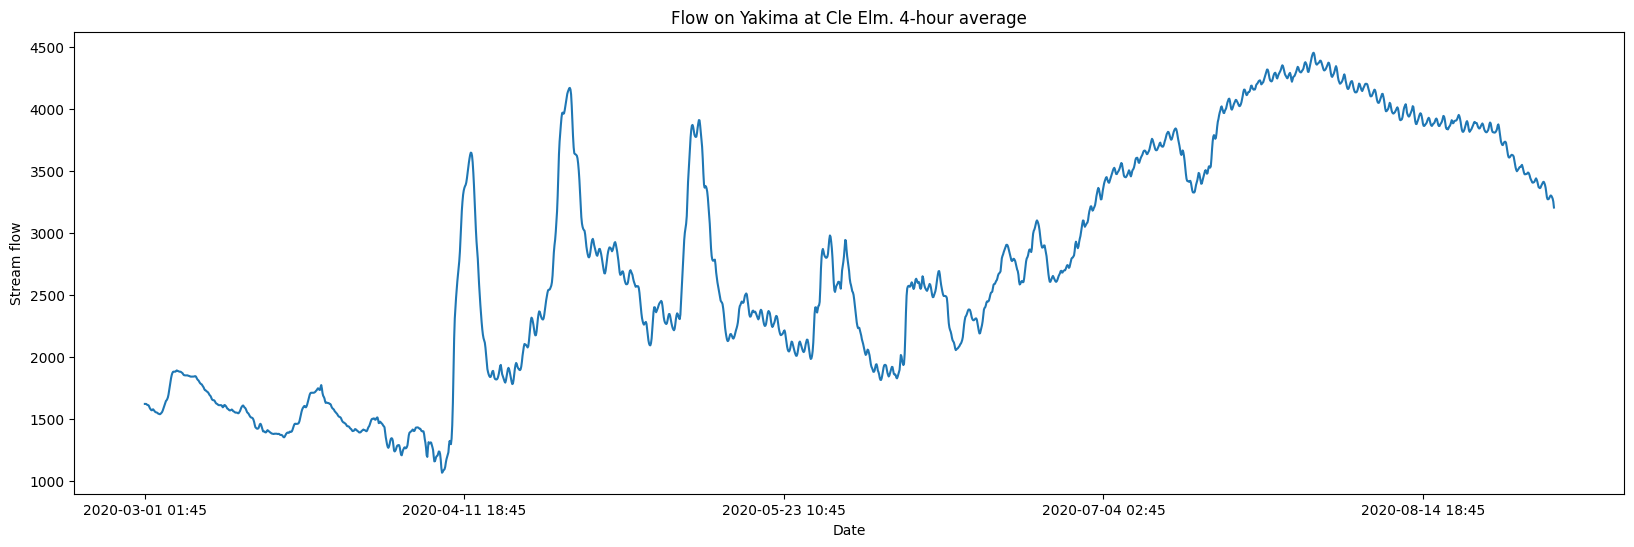

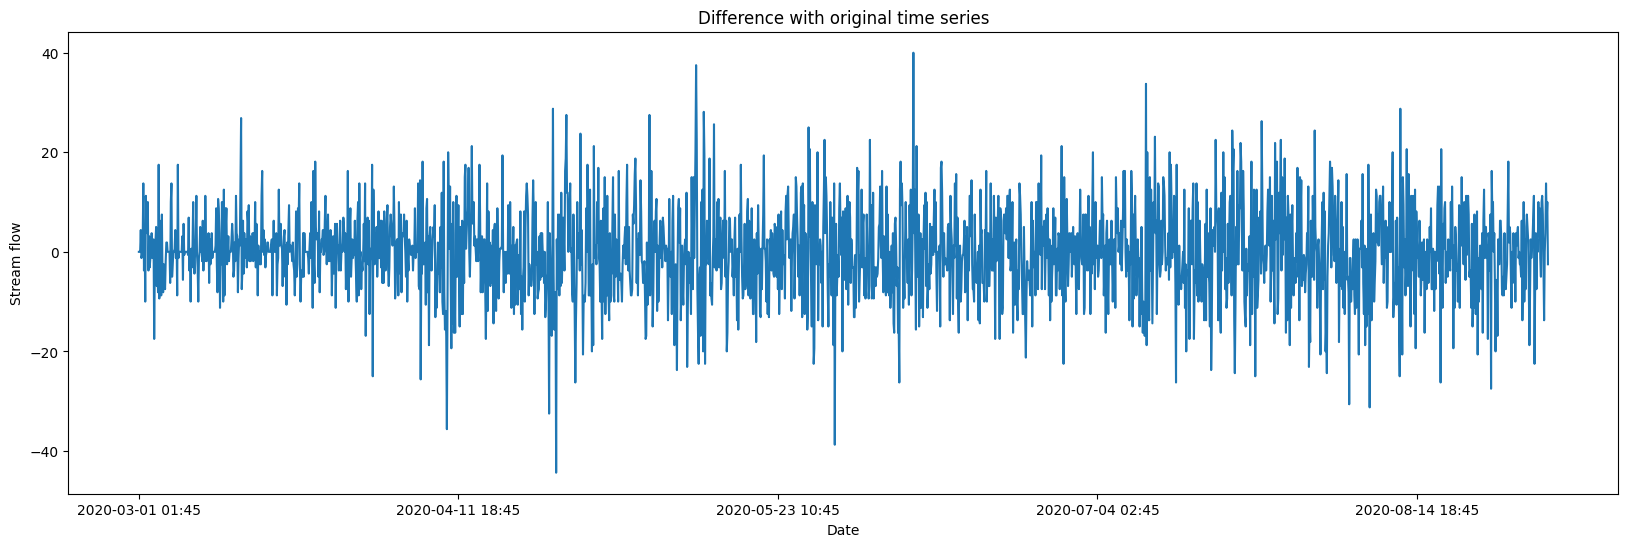

RMS error = 8.959708504022679


In [23]:
_=plot_time_series(filtered_12, title='Flow on Yakima at Cle Elm. 4-hour average')
_=plot_time_series(Yakima_difference_12, title='Difference with original time series')
print('RMS error = ' + str(np.std(Yakima_difference_12)))

Notice the following about the results above. The moving average smoother has had only minimal effect on the stream flow time series. The difference series shows only small values with respect to the range of values in the filtered series. Further, the root mean square (RMS) error is also small compared to the range of values of the filtered series.    

**Answer:** The 4-hour moving average applied to the Yakima River stream flow data showed minimal smoothing effect, with small deviations and an RMS error of approximately 8.96, indicating the filtered series closely mirrors the original time series.

> **Exercise 02-4:** You will compute and display a time series using a longer, 1-day (96 time steps) moving window with a stride of 1/2 of a day (48 time steps). You will also perform evaluation of the resulting series. For this exercise, do the following:   
> 1. Query the Yakima River stream gage data with the longer time window and stride.
> 2. Use te `window_average` function you completed in te pervios exerciese to compute the smoothed series and the difference series.
> 4. Print the length of the resulting Pandas Series.
> 5. Plot the filtered (moving average smoothed) time series.
> 6. Plot the difference series.     
> 7. Compute and display the RMSE between the smoothed series and the original series.      

Columns in the DataFrame: Index(['Stream_flow'], dtype='object')
Length of the resulting series: 366


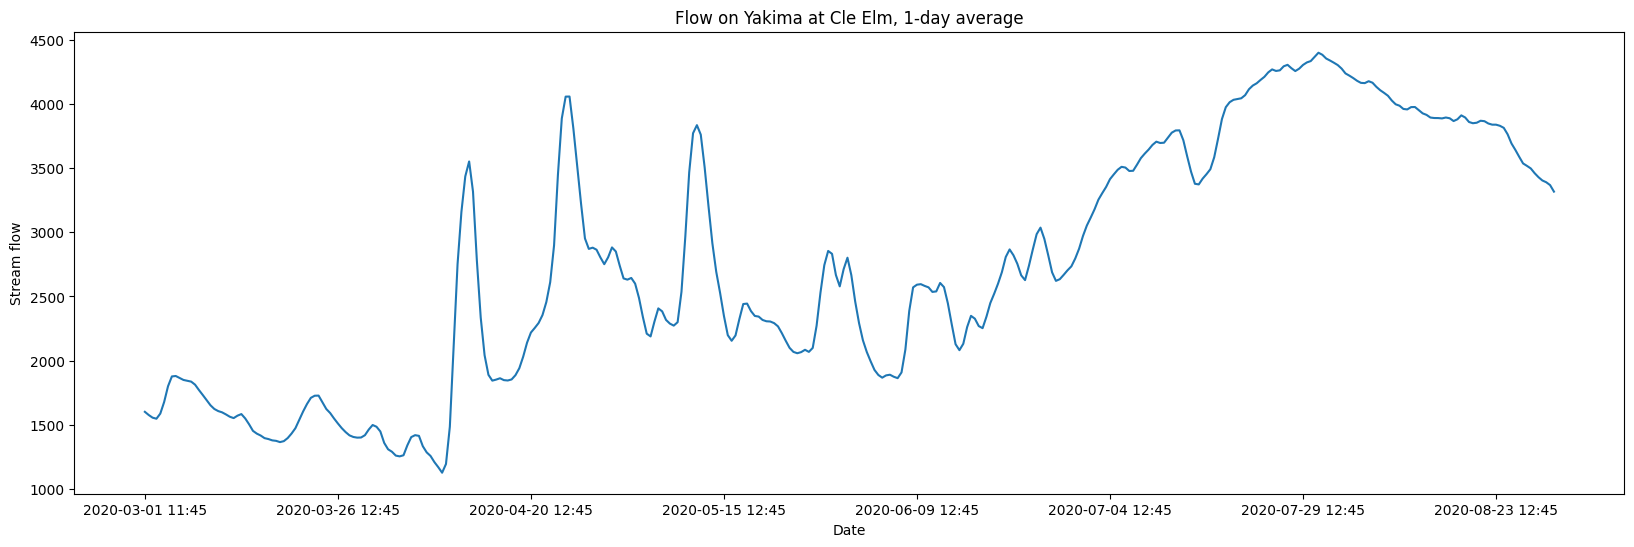

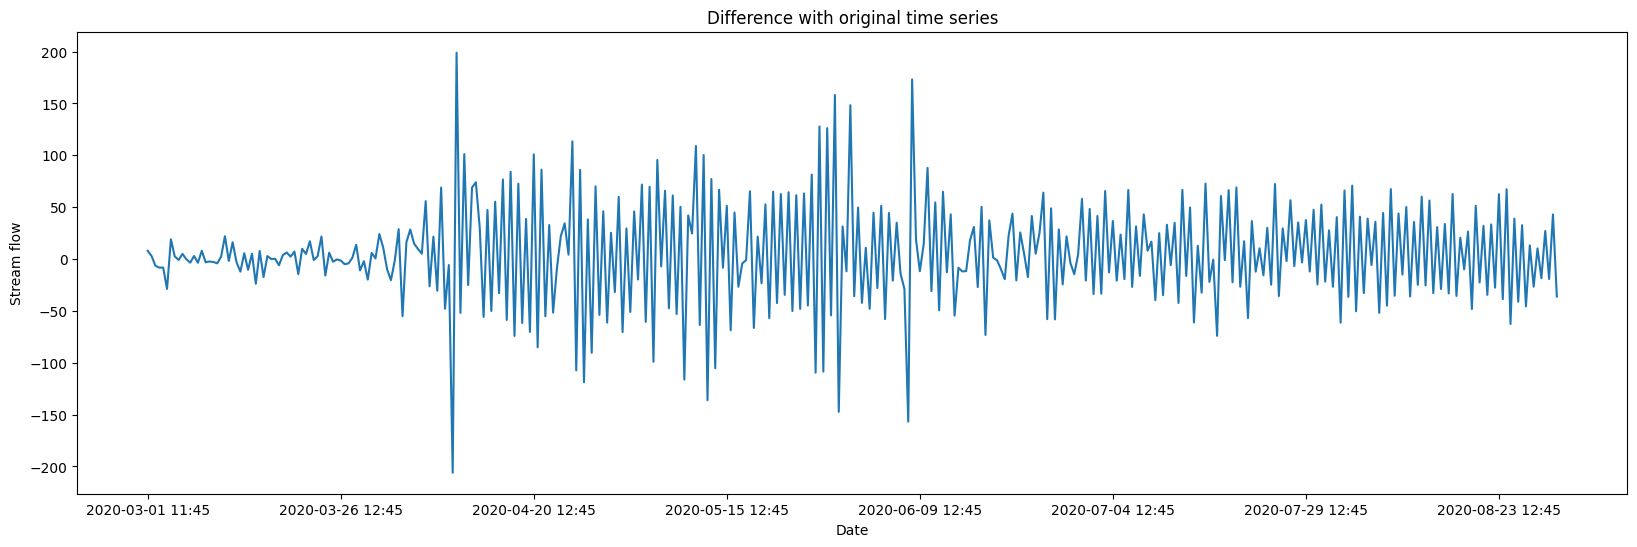

RMS error = 50.78888549548472


In [24]:
# 1. Query to create a series with only the Yakima River stream gage data
Yakima = query_stream(stream_flow, site_numbers=[12484500])

# 2. Use a longer, 1-day (96 time steps) moving window with a stride of 1/2 of a day (48 time steps)
window_length = 96
stride = 48

# Apply the window average function to compute the smoothed series and the difference series
filtered_96, Yakima_difference_96 = window_average(Yakima, length=window_length, stride=stride)

# 3. Print the length of the resulting Pandas Series
print("Length of the resulting series:", len(filtered_96))

# 4. Plot the filtered (moving average smoothed) time series
_=plot_time_series(filtered_96, title='Flow on Yakima at Cle Elm, 1-day average')

# 5. Plot the difference series
_=plot_time_series(Yakima_difference_96, title='Difference with original time series')

# 6. Compute and display the RMSE between the smoothed series and the original series
rms_error = np.std(Yakima_difference_96)
print('RMS error = ' + str(rms_error))


> Answer the following questions:   
> 1. What is the data compression ratio with respect to the original stream flow series? Is this consistent with the stride of the window?   
> 2. Compare the plots of the results of the two moving window summaries. What are the obvious differences?
> 3. How do the errors compare between the two moving window summaries, and why is this expected?       
> 4. If the goal is to measure total volume of water passing the gage on a daily and weekly basis, does the series from the longer filter contain sufficient detail?

> **Answers:**

> 1. The compression ratio can be calculated as 17660/366 =~ 48.26, consistent with the stride of 48 time steps.

> 2. The 4-hour average retains more detailed fluctuations, while the 1-day average shows smoother, more gradual changes.

> 3. The RMS error is larger for the 1-day average (50.79) compared to the 4-hour average (8.96), as expected due to greater smoothing.

> 4. The 1-day average series provides sufficient detail for measuring total water volume on daily and weekly bases.

## Exponential Decay Filters

The idea of using exponential smooth for time series analysis is an old one, dating at least to use by Weiner in the 1920s. The related idea of moving average filters was developed by Kolmogorov and Zurbenko in the 1940s. Exponential smoothers were used extensively in signal process in the 1940s. The general idea was expanded by Robert Goodell Brown (1956) and C.E. Holt (1957) and his student P.R. Winters (1960). The higher-order Holt-Winters model accounts for trend and seasonality of time series.

### Basic exponential Smoothing

Exponential smoothing uses a weighted sum of the current observation and the past smoothed value to compute a new smoothed value. This basic exponential smoothing relationship is shown below.  

$$
s_0 = x_0\\    
s_t = \alpha x_t + (1-\alpha) s_{t-1} = s_{t-1} + \alpha(x_t - s_{t-1}),\ t \gt 0
$$

The smoothing hyperparameter, $\alpha$, controls the trade-off between the last observation and the previous smoothed values. The possible values are in the range, $0 \le \alpha \le 1$. A large value of $\alpha$ puts more weight on the current observation. Whereas, a small value of $\alpha$ puts more weight on the smoothed history.      

How can we understand the exponential decay of the smoothed history of a time series? The smoothing hyperparameter, $\alpha$, an be expressed in terms of the decay constant, $\tau$ and time interval $\Delta T$ as shown below.  

$$
\alpha = 1 - e^{\big( \frac{- \Delta T}{\tau} \big)}
$$

From this relationship you can see that the influence of the smoothed history decays exponentially as $\delta T$ increases. The decay time increases as $\tau$ decreases.   

### Smoothing with higher-order terms   

The basic exponential smoothing algorithm is effective in many cases. However, the simple first order exponential smoothing method cannot accommodate time series with trend or seasonality. Higher order smoothing models are required.   

The **double exponential smoothing** or **Holt-Winters double exponential smoothing** algorithm is a second order smoothing method. Using two coupled difference equations a trend and non-seasonal component of the time series can be modeled. The model updates a smoothed measure of the non-seasonal component and the trend.   

The model is initialized with the values:   
$$
s_1 = x_1 \\
b_1 = x_2 - x_1
$$

At each time step the a pair of time difference equations are updated. The following relationships update the smoothed non-seasonal component, $s_t$, and the slope, $b_t$:   

$$
s_t = \alpha x_t + (1-\alpha) (s_{t-1} + b_{t-1}) \\
b_t = \beta(s_t - s_{t-1}) + (1 - \beta)b_{t-1}
$$

The smoothed non-seasonal component and smoothed slope can be used to compute a forecast. The relationship below computes the forecast $m$ time steps ahead.      

$$ F_{t+m} = s_t + m b_t $$   

What about seasonal components? A third-order difference relationship can updated a smoothed seasonal component, along with the smoothed non-seasonal and slope components. The details of this process are not discussed further here. The details are available elsewhere, including the [exponential smoothing Wikipedia page](https://en.wikipedia.org/wiki/Exponential_smoothing#:~:text=Exponential%20smoothing%20is%20a%20rule,exponentially%20decreasing%20weights%20over%20time.).  

### Example of Exponential Decay Filtering     

> **Exercise 02-5:** You will now create and test a single or simple exponentially weighted decay filter. This function will have a stride argument just as the window filter function. Your function, `exponential_smooth`, will have arguments of the time series, the exponential smoothing parameter and a stride. Your function will do the following:    
> 1. Initialize a list for the filtered samples with the first value of the input series. The samples list will contain the exponentially weighted smoothed samples. Make sure you save the first value in the list.   
>    a. Initialize empty lists for the output values, differences, and time index of the output values.   
>    b, Iterates over all the values of the time series starting with the second one. In this case a query is not used since for a live stream the exponential decay filter is updated each time a value arrives. In the loop update the exponentially weighted smoothed values using the first order smoothing algorithm.
>    c. If the loop index modulo the stride $= 0$ then, do the following:     
>           - Append the smothed sample value to the output list.     
>           - Compute and append the difference between the sample value at the index of the update and the updated smoothed value.     
>           - Append the time index of that sample to the index list.    
>    d. Create an output Pandas Series from the output list and the difference list using the output index list as the index of both series.   
>    e. Return both Pandas Series.   
> 8. Compute the value of $\alpha$ given $\tau = 24.0$.   
> 9. Execute your function for site number $12484500$ and arguments of the computed $\alpha$ and stride $=48$, or 12 hours.  
> 10. Print the length of the resulting series.     
> 11. Print the value of $\alpha$, given the time step and value of $\tau$.    
> 12. Pint the RMSE between the smothed series and the original values.    
> 13. Plot the smothed series and the difference series using the `plot_time_series` function.    

Length of the resulting series: 367
alpha = 0.0104
RMS error = 186.17304849839945


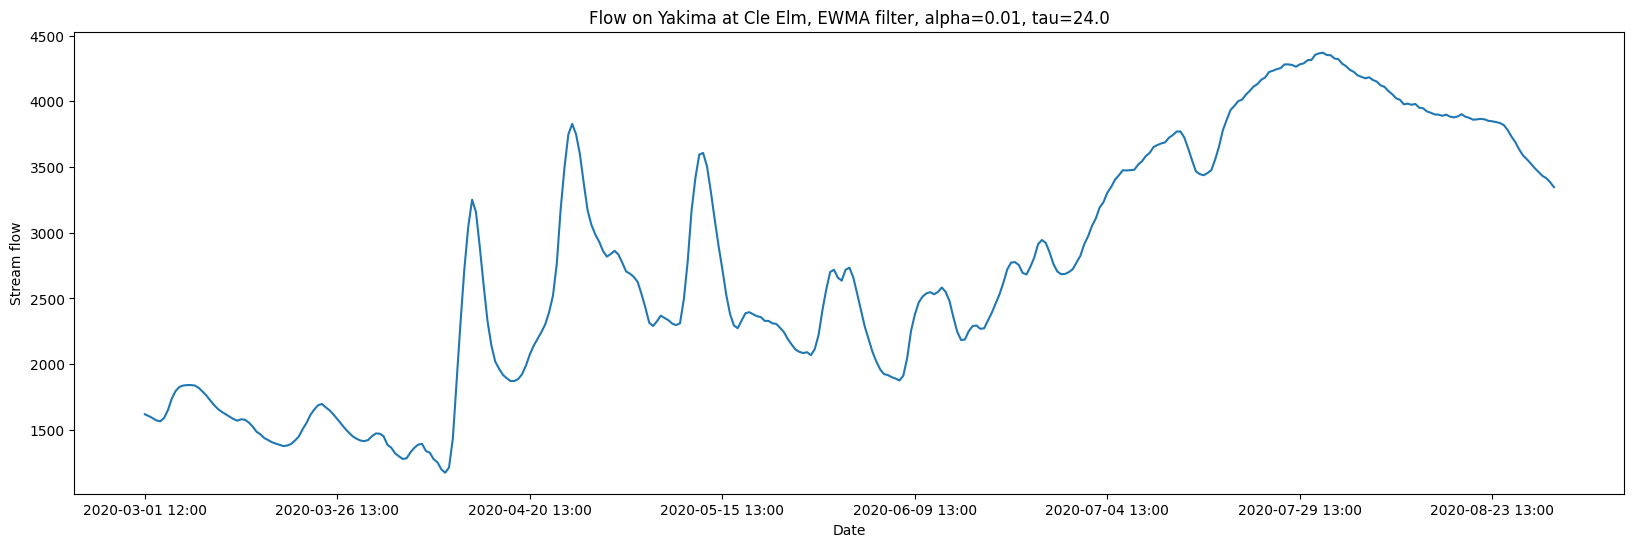

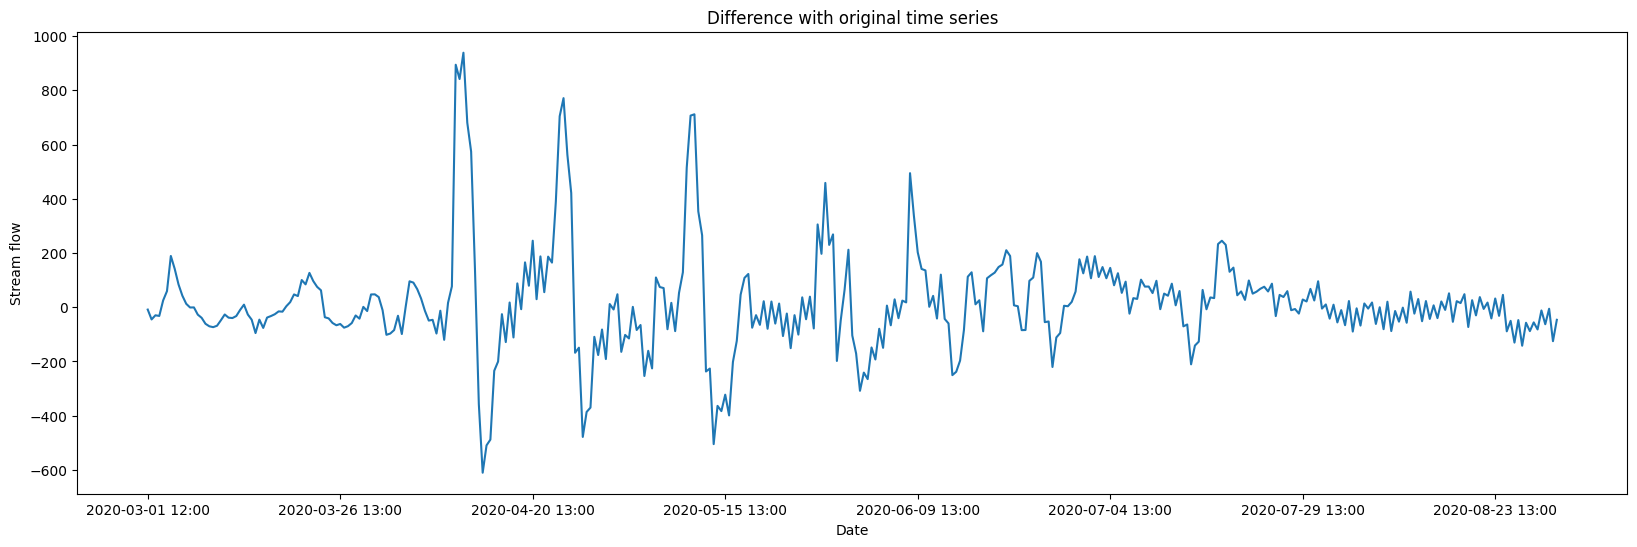

In [25]:
def compute_tau(alpha, time_step):
    '''Compute the value of tau given the time step and alpha'''
    return -time_step / math.log(1 - alpha)

def compute_alpha(tau, time_step):
    '''Compute the value of alpha given the time step and tau'''
    return 1 - math.exp(-time_step/tau)

# Exponential smoothing function
def exponential_smooth(ts, alpha=0.01, stride=8):
    # 1. Initialize a list for the filtered samples with the first value of the input series.
    samples = [ts.iloc[0]]
    # 1.a. Initialize empty lists for the output values, differences, and time index of the output values.
    out = []
    difference = []
    idx = []

    # 1.b. Iterate over all the values of the time series starting with the second one.
    for i in range(1, len(ts)):
        # Update the exponentially weighted smoothed values
        smoothed_value = samples[-1] + alpha * (ts.iloc[i] - samples[-1])
        samples.append(smoothed_value)

        # 1.c. Append values to the lists if the loop index modulo the stride is 0.
        if i % stride == 0:
            out.append(smoothed_value)
            difference.append(ts.iloc[i] - smoothed_value)
            idx.append(ts.index[i])

    # 1.d. Create an output Pandas Series from the output list and the difference list using the output index list as the index of both series.
    out_series = pd.Series(out, index=idx)
    difference_series = pd.Series(difference, index=idx)

    # 1.e. Return both Pandas Series.
    return out_series, difference_series

# 2. Compute the value of alpha given tau = 24.0
time_step = 15 / 60  # Step time in hours
stride = 48  # Stride in samples
tau = 24.0  # Decay time in hours
alpha = compute_alpha(tau, time_step)

# 3. Execute the function for site number 12484500 with computed alpha and stride
smoothed_24, difference_24 = exponential_smooth(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]), alpha=alpha, stride=stride)

# 4. Print the length of the resulting series
print("Length of the resulting series:", len(smoothed_24))

# 5. Print the value of alpha
print('alpha = ' + str(round(alpha, 4)))

# 6. Print the RMSE between the smoothed series and the original values
rms_error = np.std(difference_24)
print('RMS error = ' + str(rms_error))

# 7. Plot the smoothed series and the difference series
_=plot_time_series(smoothed_24, title='Flow on Yakima at Cle Elm, EWMA filter, alpha=' + str(round(alpha, 3)) + ', tau=' + str(tau))
_=plot_time_series(difference_24, title='Difference with original time series')


> Provide short answers to the following questions:   
> 1. Are the number of smoothed samples correct for the stride of the exponential decay filter selected?     
> 2. How does the exponentailly smoothed series compare to the original series in terms of frequency components?      
> 3. Given the value of $\tau$ (in hours) what does this tell you about the decay length and smoothing of the filter?     
> 4. Examine the plot of the difference series. What do the frequency components of this difference series tell you about the smoothing?     
> 5. Given the range of values in the difference series and the RMSE is it reasonable to use the smoothed series if we are primarily interested in daily averages?          
> **End of exercise.**

> **Answers:**

> 1. Yes, the number of smoothed samples (367) is correct for the stride of 48 samples (12 hours), consistent with the original series length and stride.

> 2. The exponentially smoothed series shows fewer high-frequency components, meaning it smooths out rapid fluctuations and retains the overall trend more effectively.

> 3. The value of $\tau$=24 hours indicates a relatively slow decay, providing significant smoothing by weighing past observations more heavily over a longer period.

> 4. The difference series contains higher frequency components, indicating that the smoothing filter effectively reduces short-term fluctuations while preserving long-term trends.

> 5. Yes, the range of values in the difference series and the RMSE suggest that the smoothed series is suitable for calculating daily averages, as it retains essential trends and reduces noise.

> **Exercise 02-6:** A question we should ask is what happens if you increase the smoothing constant of the exponential decay filter? In other words, what is the effect of giving greater weight to the most recent values? To find out do the following:  
> 1. Compute a value of alpha given $\tau = 1.0$, one hour.     
> 2. Execute the `exponential_smooth` function with arguments of the computed value of $\alpha$ and `stride=4`.
> 3. Print the length of the resulting Pandas Series.
> 4. Print the value of $\alpha$ computed.
> 5. Compute and print the RMSE of the difference series.   
> 6. Plot the smoothed time series using the `plot_time_series` function.   
> 7. Plot the difference series using the `plot_time_series` function.

Series length = 4414
alpha = 0.2212
RMS error = 15.103109941294163


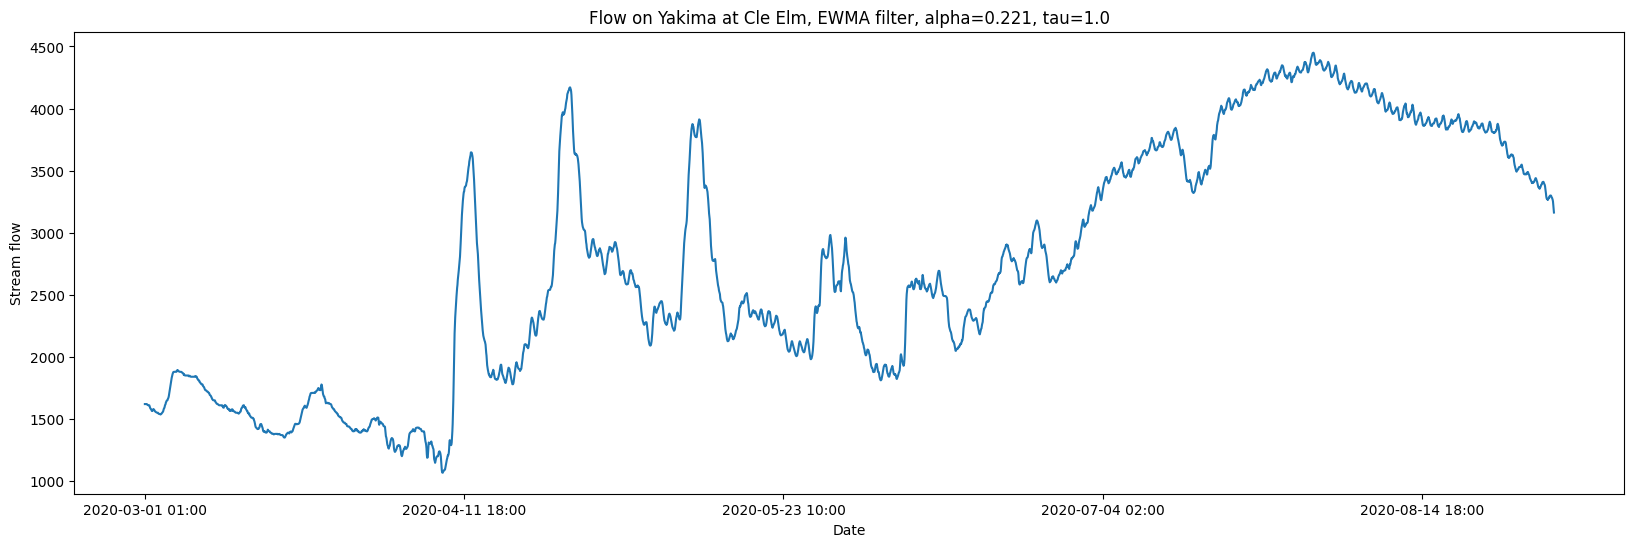

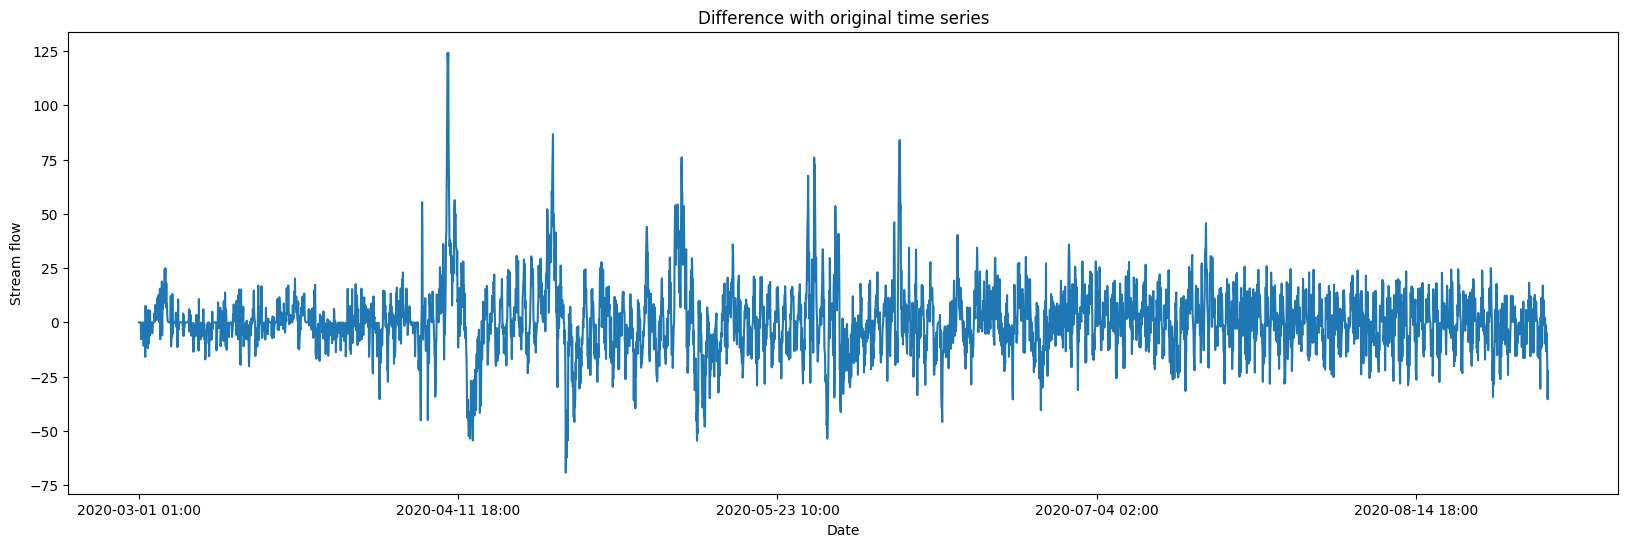

In [26]:
# 1. Compute a value of alpha given tau = 1.0
tau = 1.0  # Decay time in hours
time_step = 15 / 60  # Step time in hours
alpha = compute_alpha(tau, time_step)

# 2. Execute the exponential_smooth function with arguments of the computed value of alpha and stride=4
stride = 4
smoothed_01, difference_01 = exponential_smooth(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]), alpha=alpha, stride=stride)

# 3. Print the length of the resulting Pandas Series
print('Series length = ' + str(len(smoothed_01)))

# 4. Print the value of alpha computed
print('alpha = ' + str(round(alpha, 4)))

# 5. Compute and print the RMSE of the difference series
rms_error = np.std(difference_01)
print('RMS error = ' + str(rms_error))

# 6. Plot the smoothed time series using the plot_time_series function
_=plot_time_series(smoothed_01, title='Flow on Yakima at Cle Elm, EWMA filter, alpha=' + str(round(alpha, 3)) + ', tau=' + str(tau))

# 7. Plot the difference series using the plot_time_series function
_=plot_time_series(difference_01, title='Difference with original time series')


> Compare the plot of this time series to the previous series less smoothing and provide short answers to the following questions.   
> 1. How do the lengths of the smoothed series compare and is this differnce consistent with the stride lengths?    
> 2. What is the main difference you can see between these smoothed series in terms of frequency components and why is this expected given the decay times?     
> 3. How can you compare the difference series in terms of frequency components and why is this expected given the decay times?
> 4. How do the difference values and RMSE values compare between two values of $\tau$ and why is ths expected?    
> **End of exercise.**

> **Answers:**

> 1. The length of the smoothed series with $\tau$=1.0 is 4414, while the length with $\tau$=24.0 is 367. This difference is consistent with the stride lengths, as a smaller stride (4 vs 48) results in more frequent sampling and thus a longer series.

> 2. The series with $\tau$=1.0 retains more high-frequency components and shows less smoothing, while the series with $\tau$=24.0 shows fewer high-frequency components and more smoothing. This is expected because a shorter decay time gives more weight to recent values, preserving more short-term variations.

> 3. The difference series for $\tau$=1.0 shows smaller fluctuations compared to $\tau$=24.0, which has larger deviations. This is expected because a shorter decay time results in less smoothing, leading to smaller differences from the original series.

> 4. The RMSE for $\tau$=1.0 is lower (15.10) compared to $\tau$=24.0 (186.17). This is expected because a shorter decay time results in a smoother series that stays closer to the original values, reducing the overall error.


> **Exercise 02-7:** So far, we have picked a stride that is about 1/2 the decay time, which is a typical choice. The next question to ask is what is the effect of using a much longer stride? A longer stride reduces the number of smoothed samples used for further processing. To find out repeate the calculations and plotting of exercise 2-5, but with stride $=12$.

Series length = 1471
alpha = 0.0104
RMS error = 183.17443752544716


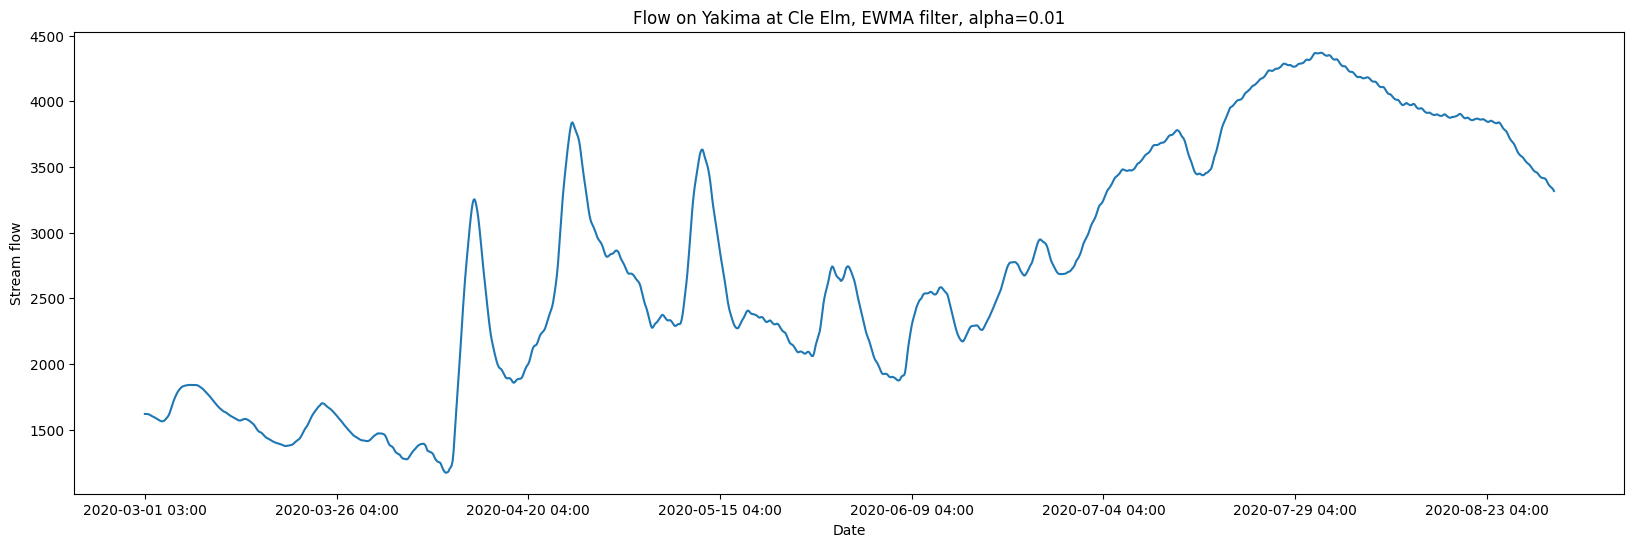

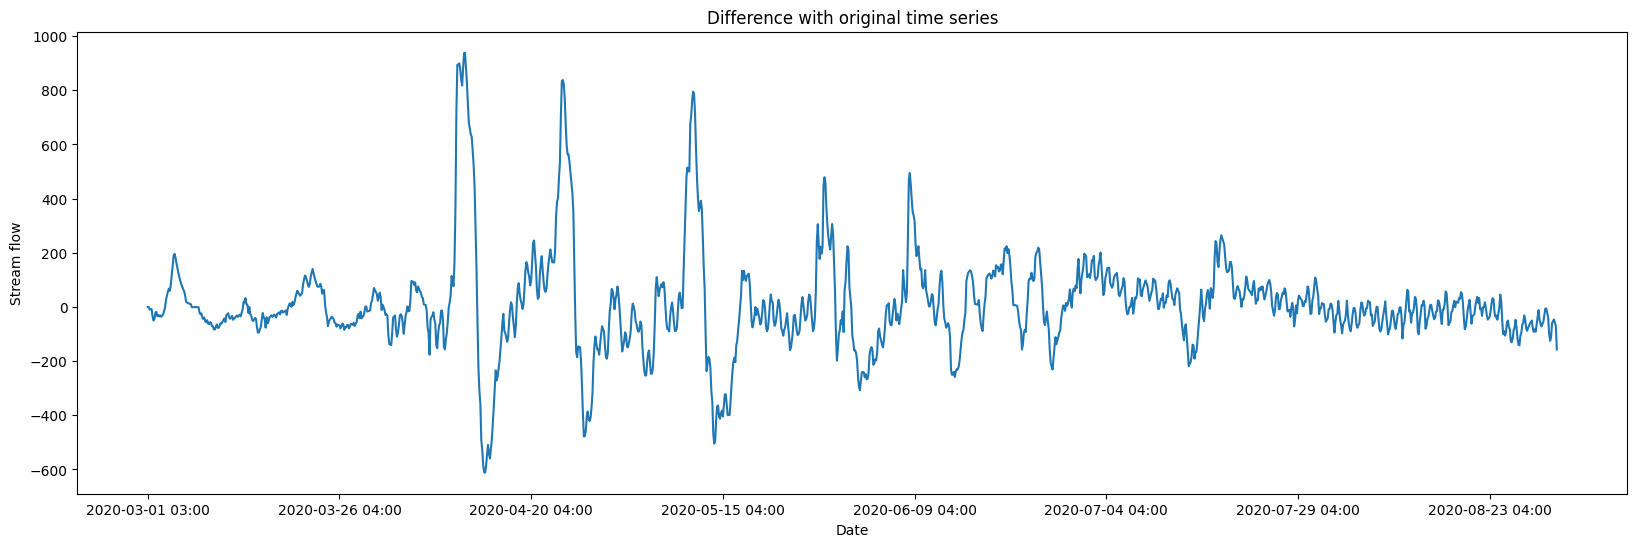

In [27]:
# 1. Compute a value of alpha given tau = 24.0 (already given in Exercise 02-5)
tau = 24.0  # Decay time in hours
time_step = 15 / 60  # Step time in hours
alpha = compute_alpha(tau, time_step)

# 2. Execute the exponential_smooth function with arguments of the computed value of alpha and stride=12
stride = 12
smoothed_24_96, difference_24_96 = exponential_smooth(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]), alpha=alpha, stride=stride)

# 3. Print the length of the resulting Pandas Series
print('Series length = ' + str(len(smoothed_24_96)))

# 4. Print the value of alpha computed
print('alpha = ' + str(round(alpha, 4)))

# 5. Compute and print the RMSE of the difference series
rms_error = np.std(difference_24_96)
print('RMS error = ' + str(rms_error))

# 6. Plot the smoothed time series using the plot_time_series function
_=plot_time_series(smoothed_24_96, title='Flow on Yakima at Cle Elm, EWMA filter, alpha=0.01')

# 7. Plot the difference series using the plot_time_series function
_=plot_time_series(difference_24_96, title='Difference with original time series')


> Compare the result you just created with that from Exercise 2-5 and answer the following questions:
> 1. Is the error series or RMSE significantly different, or nearly the same?
> 2. Why do you think foregoing outcome is expected?        
> **End of exercise.**

> **Answers:**

> 1. The RMSE for stride 12 (183.17) is nearly the same as the RMSE for stride 48 (186.17) from Exercise 02-5. The error series also shows similar patterns of deviation from the original series.

> 2. This outcome is expected because the exponential smoothing with a larger decay time ($\tau$=24.0) dominates the effect, resulting in similar overall smoothing regardless of the stride length. The stride primarily affects the sampling frequency of the smoothed series but not the smoothing effect itself.


## Filtering Discrete Events  

In many cases our goal is to filter discreete events based on some type of identifier. The identifier is a hash of nearly any hashable data type. Many examples of these data types include, string customers identifiers, numeric event identifiers, IP addresses, email addresses.  

One example of such a method is the [**Bloom filter**](https://en.wikipedia.org/wiki/Bloom_filter). A Bloom filter is quite efficient in terms of computing and memory.  However, the Bloom filter does not allow for deleting matches once they are added to the hash table. An alternative is a **[quotient filter](https://en.wikipedia.org/wiki/Quotient_filter)**. The quotient filter keeps a count of events for each hash. As a result, an event identifier can be removed from the table by decrementing the counts for the hashes. To perform this extra operation the quotient filter uses more memory and is a bit less computationally efficient.   

Both Bloom filters and quotient filters operate by the same principle. A hash table of key-values pairs is created. The keys are the hashes of the event identifiers. For a Bloom filter, the value is binary, the event is in the table or it is not. The quotient filter on the other hand, maintains a count of events in each bucket. The count can be incremented as new instances are encountered, or decrimented to delete events.     

In the following exercises, you will construct a Bloom filter using a bit array and the Python [mmh3 package](https://github.com/hajimes/mmh3?tab=readme-ov-file). The mmh3 package implements the widely used [MurmurHash (MurmurHash3)](https://en.wikipedia.org/wiki/MurmurHash) non-cryptographic hash algorithm.                      

### Instantiate the identifier lists      
To start the example, we generate lists of random customer identifiers (IDs) for customers and non-customers by the following steps.     
1. Initialize the arguments for the generate of the customer ID lists.  
2. Randomly generated lists of customer and non-customer ids are created. A multiplier is used to ensure that some IDs values are outside the range of the length of the hash table. The customer and non-customer identifiers are all integers.   
3. The non-customer list is filtered to ensure there are no identifiers common with the customer list.     
4. The lengths of the lists and a sample of the customer key values are printed.  

Execute the code in the cell below.

In [28]:
number_of_hashes = 1024
ID_multiplier = 39
number_customers = 100
number_not_customers = 200

nr.seed(4565)
customers = [int(ID_multiplier * number_of_hashes * i) for i in nr.uniform(size=number_customers)]
not_customers = [int(ID_multiplier * number_of_hashes * i) for i in nr.uniform(size=number_not_customers)]

## Ensure there are no common ids between customers and non-customers
del_list = []
for i in range(len(not_customers)):
    if not_customers[i] in customers: del_list.append(i)
for i in sorted(del_list, reverse=True):
    del not_customers[i]

print('Number of non-customers = ' + str(len(np.unique(not_customers))))
print('Number of customers = ' + str(len(np.unique(customers))))
print(customers[:20])

Number of non-customers = 200
Number of customers = 100
[33865, 23066, 4563, 3766, 23319, 32656, 34824, 13512, 26942, 12292, 26732, 18717, 31650, 19425, 456, 31327, 14815, 21627, 39414, 3196]


### Using the Murmur Hash

You will use the 32 bit Murmur hash function implemented in the Python mmh3 package to create a Bloom fliter. First we will investigate some basic properties of the Murmur hash. Specifically, we will investigate how uniform the hash values computed are by the following steps:   
1. Created a hash table of length 1024. The table is filled with hashes computed from random integers. Notice that the `mmh3.hash` function only accepts a string argument, requiring the integer to be wrapped in the `str()` function.
2. A histogram and cummulative density plot of the hash values are displayed.
3. The number of hash collisions is computed and displayed.    

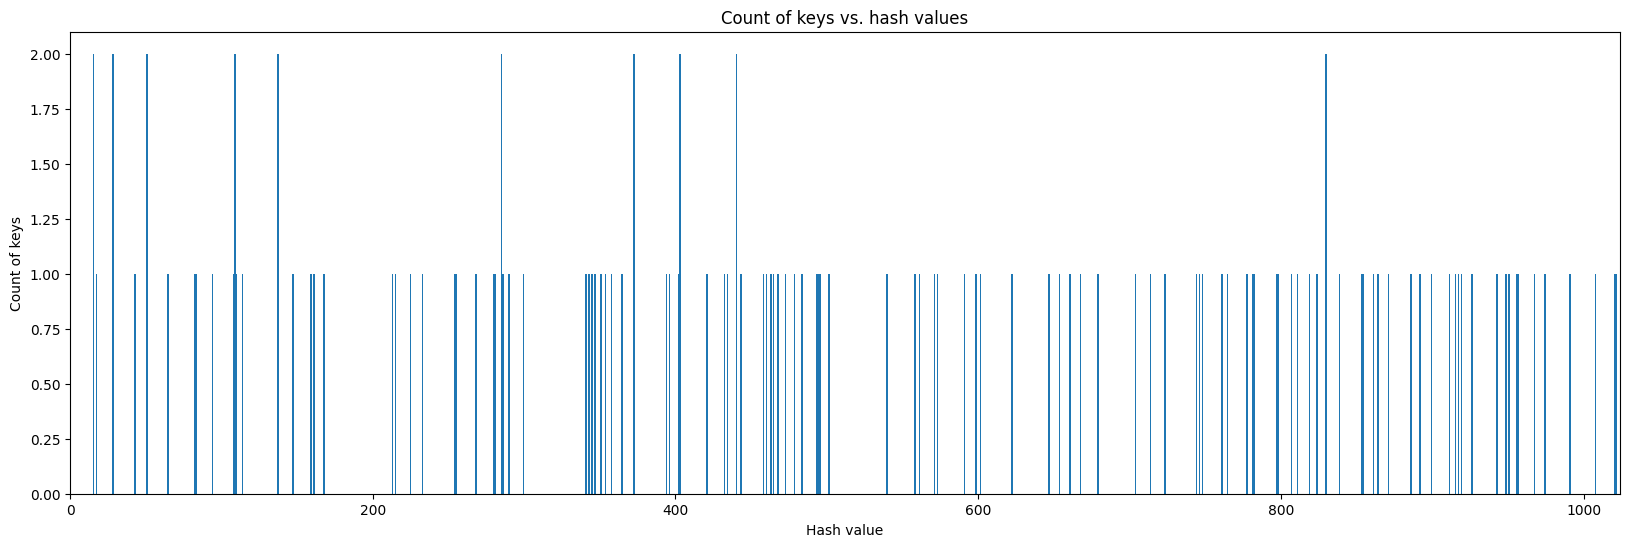

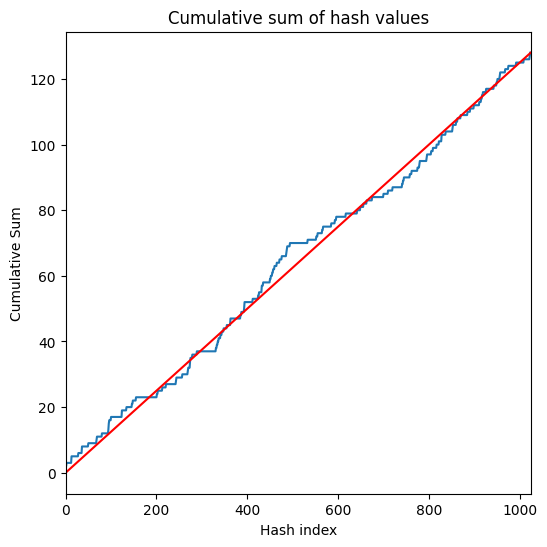

Number of collisions = 10


In [29]:
filter_length = 1024
number_samples = 128
multiplier = 1019

## Compute random numbers and find the corresponding hash values
samples = [int(multiplier * filter_length * i) for i in nr.uniform(size=number_samples)]
hash_list = [mmh3.hash(str(i)) % filter_length for i in samples]

## Histogram of the hash values
fig, ax = plt.subplots(figsize=(20, 6))
counts, bins, _ = ax.hist(hash_list, bins=filter_length);
ax.set_ylabel('Count of keys');
ax.set_xlabel('Hash value');
ax.set_title('Count of keys vs. hash values');
ax.set_xlim(0.0, filter_length)
plt.show();

## Cumulative density plot of the hash values
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(range(len(counts)), np.cumsum(counts))
ax.plot([0.0,len(counts)], [0.0,len(hash_list)], color='red');
ax.set_ylabel('Cumulative Sum');
ax.set_xlabel('Hash index');
ax.set_title('Cumulative sum of hash values');
ax.set_xlim(0.0, filter_length)
plt.show();

## Compute and display the number of hash collisions
print('Number of collisions = ' + str(int(sum([count - 1 if count>1 else 0 for count in counts]))))

> **Exercise 02-8:** Compare the plots shown above to the plots of the hash function using a prime number key created for Exercise 01-1. Is the Murmur hash function more or less optimal compared to the function tested in Exercise 01-1 and why?    

> **Answer:** The Murmur hash function has more hash collisions (10) compared to the prime number key hash function (6), making it slightly less optimal in terms of collision avoidance. The Murmur hash function provides a more uniform distribution of hash values, which is expected due to its design for spreading hash values evenly over a range. This makes it advantageous for certain applications despite having slightly more collisions.

### Create Bloom filter and insert function    

You will now instatiate a Bloom filter and create an insert function. As a first step, execute the code in the cell beolow to instantiate the Bloom filter as an empty bit array.     

In [30]:
filter_length = 1024

bloom_filter = bitarray(filter_length)
bloom_filter

bitarray('000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

> **Exercise 2-9:** You will now complete and test a function to insert an event identifier into the Bloom filter array. To complete the code in the cell below do the following:
> 1. Iterate over the hash keys. The key for mmh3 is just an integer.   
> 2. For the value, `x`, and integer key compute the hash. Make sure you take the modulo with the length of the Bloom filter.
> 3. Set the bit indexed by the hash value to 1.
> 4. Return the Bloom filter array.        
> Execute your code to add the customers to the hash table.

In [31]:
n_hashes = 3

def bloom_insert(x, bloom_filter, n_hashes=3):
    # 1. Iterate over the hash keys
    for i in range(n_hashes):
        # 2. Compute the hash and take modulo with the length of the Bloom filter
        hash_value = mmh3.hash(x, i) % len(bloom_filter)
        # 3. Set the bit indexed by the hash value to 1
        bloom_filter[hash_value] = 1
    # 4. Return the Bloom filter array
    return bloom_filter

# Add customers to the hash table
for customer in customers:
    bloom_filter = bloom_insert(str(customer), bloom_filter, n_hashes=n_hashes)

bloom_filter


bitarray('000000111010000001000001000110000011001000000000000011000000000001000010001000100000110000101110010000100011010000010010010101000100001000010001000000100000011000000110011000101000100101001011010000000000000110101110010000000000010000101011000000111000011111111000000000100010000000000000001100000000000100000100000011110100100000000010001001100000000010110111100000110001000000010101000000100000000000001000011000000010010101100100100010000100000000011000011110100000011000010001000100100001000001000001100000000001001010110000000101011000000000000101000100010000000000110010000000001100001001000000101000000010100000010000100000000000000000000010001000010001001000000000000000010000000001101000011000000100000000000011010000011000110010000100001010000100010000010000100000000101010000010010100000001010011000000000000100010011001000000001100100001001110100100001000000100000000000100011100001011000110000000000000100110000000100101000001010010000001100111000010000000000000000010010000010

> Notice that most bits in the Bloom filter array are still 0, and only a small fraction of the bits set to 1.
>
> Next, you will complete the `bloom_query` function in the cell below. Recall that a query returns True only if all bits indexed by the hash values are 1. To complete the function, do the following:     
> 1. Set a counter variable to 0.     
> 2. Iterate over the number of hashes.     
> 3. Compute the hash for the input value, `x`, and integer hash key.    
> 4. If the bit value indexed for by the key equals 1, add 1 to the counter value.      
> 5. If the counter value equals the number of hashes, return True, and if not, return False.     
> Now, execute the code in the cell below to test your function and find the number of false positives.    

In [32]:
def bloom_query(x, bloom_filter, n_hashes=3):
    # 1. Set a counter variable to 0
    counter = 0
    # 2. Iterate over the number of hashes
    for i in range(n_hashes):
        # 3. Compute the hash for the input value, x, and integer hash key
        hash_value = mmh3.hash(x, i) % len(bloom_filter)
        # 4. If the bit value indexed by the key equals 1, add 1 to the counter value
        if bloom_filter[hash_value] == 1:
            counter += 1
    # 5. If the counter value equals the number of hashes, return True, and if not, return False
    return counter == n_hashes

# Test the function and find the number of false positives
false_positives = 0
for customer in not_customers:
    if bloom_query(str(customer), bloom_filter, n_hashes=n_hashes):
        false_positives += 1
print('Total number of false positives = ' + str(false_positives))

Total number of false positives = 2


> For a perfect (uniformly distributed) hash function the theoretical false positive rate can be computed by the following relationship:  > $$P(false\ positive) = \Big[1 - exp \big(\frac{- k n}{m} \big) \Big]^k$$    
> Where,
> - $k = $ number of hash functions.    
> - $m = $ length of the hash table.   
> - $n = $ number of identifiers in the hash table.
>  
> Now answer the following questions:     
> 1. Given this result, what is the emperical false positive rate?     
> 2. How does the observed false positive rate compare to the theoretical rate? You should create a function to compute the theoretical false positive rate, which you can use for the next exercise. Name your function `false_positive_rate` with arguments, number of events, length of the bit array, and number of hashes.      

In [33]:
def false_positive_rate(num_events, length_bit_array, num_hashes):
    return (1 - math.exp(-num_hashes * num_events / length_bit_array)) ** num_hashes

# Given values
n = number_customers  # number of identifiers (customers)
m = filter_length  # length of the bit array
k = n_hashes  # number of hash functions

# Calculate the theoretical false positive rate
theoretical_fp_rate = false_positive_rate(n, m, k)
print('Theoretical False Positive Rate =', theoretical_fp_rate)


Theoretical False Positive Rate = 0.01637826799443077


> **Answers:**

> 1. The empirical false positive rate is calculated as 2/200 = 0.01. The theoretical false positive rate is 0.0164, as per the output above.

> 2. The empirical false positive rate (0.01) is slightly lower than the theoretical false positive rate (0.0164). This slight difference is expected due to the randomness and practical implementation nuances.

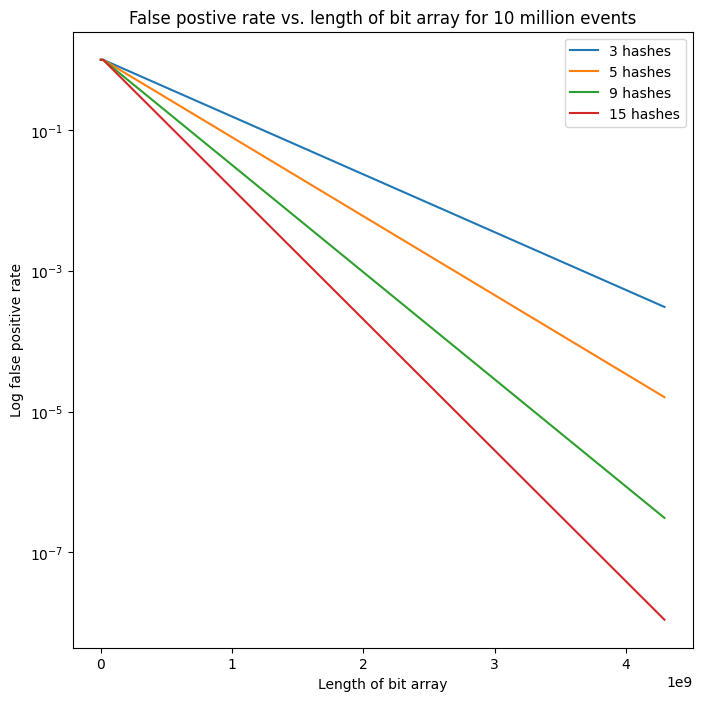

In [34]:
#m_list = [1e+14, 1e+1, 1e+16]
m_list = [2**12, 2**16, 2**24, 2**32]
k_list = [3, 5, 9, 15]
n = 10e+7

fig, ax = plt.subplots(figsize=(8,8))
for k in k_list:
    fp_list = [false_positive_rate(n, m, k) for m in m_list]
    ax.plot(m_list, fp_list, label=str(k) + ' hashes');
#    ax.plot(k_list, fp_list, label="{:.1E}".format(Decimal(m)) + ' bit array');
ax.set_yscale('log');
ax.set_ylabel('Log false positive rate');
ax.set_xlabel('Length of bit array');
ax.set_title('False postive rate vs. length of bit array for 10 million events');
ax.legend();

> Finally, answer these questions:    
> 3. What is the relationship between length of the bit array and false error rate, and why do you think this makes sense?     
> 4. How does increasing the number of hashes affect the false positive rates, and why do you think this makes sense?       
> **End of exercise.**

> **Answers:**

> 3. The relationship between the length of the bit array and the false positive rate is inversely proportional; as the length of the bit array increases, the false positive rate decreases. This makes sense because a larger bit array reduces the probability of multiple keys mapping to the same bit positions, thus lowering the chance of false positives.

> 4. Increasing the number of hashes reduces the false positive rates up to a certain point, beyond which it may start to increase again. This happens because more hash functions spread out the keys more evenly across the bit array, reducing collisions. However, too many hashes can lead to excessive setting of bits, increasing false positives.

## Applying the Quotient Filter

The quotient filter is an improvement on a Bloom filter, and uses a more compact hashing method. Like Bloom filters, quotient filters are not particularly difficult to implement. There are also several Python packages that support Bloom and quotient filters. For the following exercise you will use the [PyProbabilies](https://pyprobables.readthedocs.io/en/latest/index.html) package.     

> **Exercise 02-10:** In this exercise you will work with a quotient filter. To instantiate and add hashes for customer IDs do the following:   
> 1. Instantiate the quotient filter using the [QuotientFilter](https://pyprobables.readthedocs.io/en/latest/code.html#probables.QuotientFilter) funciton using default argument values. Name your filter object `quotient_filter`.      
> 2. To get a feel for the quotient filter created print the following attributes of the filter object, `quotient`, `remainder` and `num_elements`.     
> 3. Iterate over the customer list and add the customer identifier to the quotient filter using the `add` method. Note that the key argument must be of a string type.
> 4. Print the `elements_added` attribute of the quotient filter.
> Execute your code.   

In [35]:
# 1. Instantiate the quotient filter
quotient_filter = QuotientFilter()

# 2. Print attributes of the quotient filter
print(f'Quotient: {quotient_filter.quotient}')
print(f'Remainder: {quotient_filter.remainder}')
print(f'Number of elements: {quotient_filter.num_elements}')

# 3. Add customer identifiers to the quotient filter
for customer in customers:
    quotient_filter.add(str(customer))

# 4. Print the number of elements added to the quotient filter
print('Elements added = ' + str(quotient_filter.elements_added))


Quotient: 20
Remainder: 12
Number of elements: 1048576
Elements added = 100


> Next, you will query the quotient filter with the identifiers in the not_customer list, by executing the code in the cell below.  

In [37]:
false_positives = 0
for customer in not_customers:
    if quotient_filter.check(str(customer)): false_positives += 1
print('Total number of false positives = ' + str(false_positives))

Total number of false positives = 0


> Compare the false positive rates of the Bloom filter example of Exercise 2-9 and the quotient filter. Can you see that one filter has an advantage for this case and why?  

> **Answer:** The quotient filter, in this case, shows no false positives, indicating it is more reliable for this dataset and scenario. The primary reason for this advantage is that the quotient filter keeps track of the count of events and can handle duplicates more effectively. This results in fewer (or no) false positives compared to a Bloom filter.

## Count Min Sketch

The probabilistic count min sketch algorithm uses multiple hash functions in an efficient data structure to estimate

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) is generally considered a model for activity of online user activity, spot event attendance, and other human activities. One possible model for this behavior is the [Zipf-Mandelbrot distribution](https://en.wikipedia.org/wiki/Zipf%E2%80%93Mandelbrot_law), with the following **probability mass function**:   

$$f(k,N,\alpha,\beta)=\frac{1/(k + \beta)^\alpha}{H_{N,q,s}}$$
where:   
$k=$ rank in set of size $N$.       
$\alpha$ abd $\beta$ are parameters.     
$H_{N,q,s}=\sum^N_{k=1} 1/(k + \beta)^\alpha$



Text(0.5, 1.0, 'Density of Zipf distribution')

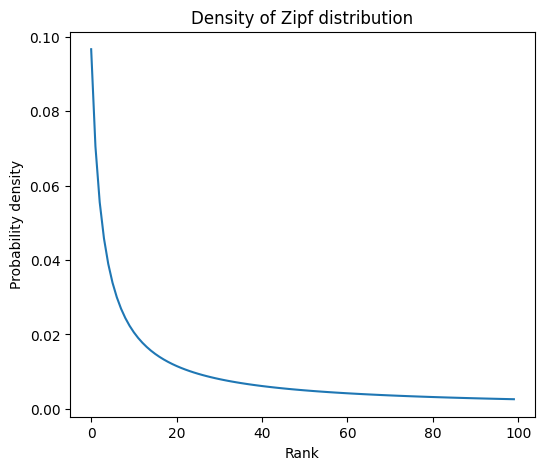

In [38]:
alpha = 1.0
beta = 2.7
zipf = [1/(i + beta)**alpha for i in range(len(customers))]
zipf = np.divide(zipf, np.sum(zipf))

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(range(len(customers)), zipf)
ax.set_ylabel('Probability density')
ax.set_xlabel('Rank')
ax.set_title('Density of Zipf distribution')

Notice the rapid decay of this distribution with event identifier. This rapid decay of event frequency is often observed in many real-world phenomenon.    

Next, execute the code in the cell below to generate a data set using the Zipf-Mandelbrot distribution of events just computed.  

In [ ]:
n_samples = int(10e+5)
stream = np.random.choice(customers, size=n_samples, p=zipf)
stream[:200]

Notice the random nautre of the indentifiers in the first 200 events in the stream.  

### Applying the Heavy Hitters Algorithm

A variation on the count-min-sketch algorithm is used to find the **heavy hitters**, or the event ids that occur most frequently. This approach allows one to find the counts of a pre-determined number of common events, using the small memory footprint of the count-min-sketch algorithm, but at a cost of some additional compuation for sorting and bookkeeping.  

> **Exercise 02-11:** You will now use the [probables.HeavyHitters](https://pyprobables.readthedocs.io/en/latest/code.html) function to find the 20 event identifiers with the highest event count. Do the following:
> 1. Conmpute the required width of the data structure to achieve an approximate 1% error rate using the following relationship:     
>    $$width = 2^{log_2(e/\epsilon)}$$       
>    To perform this calculation use the Python `math.log2` functiion and the `math.ceil` function to round up the next highest integer. Display the computed result
> 3. Compute the required depth to ensure a less than 1% probability, $\delta$, of breaching the error bound using the following relationship:
>    $$depth = ln(1/\delta)$$
>    Use the `math.ceil` function to round up to the next highest integer. Display the computed result.    
> 5. Instantiate a HeavyHitters object with the arguments computed above and `num_hitters = 20`.
> 6. Iterative over the events in the stream applying the `add` method for each event, with the num_els argument set to 1. Make sure you coerce the integer identifier to a string.  
> 7. Save the `heavy_hitters` attribute to a variable. The data structure for this attribute is a dictionary.         

In [ ]:
## Put your code below



heavy_hitters = heavy_hitters.heavy_hitters

> 4. Execute the provided function, using the `heavy_hitters` attribute variable you have saved.   

In [ ]:
def display_dist(hitters):
    heavy_hitters = np.flip(np.sort(list(hitters.values())))
    print('The ordered list of heavy hitters:')
    print(heavy_hitters)

    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot([x + 1 for x in range(len(heavy_hitters))], heavy_hitters)
    ax.set_ylabel('Count')
    ax.set_xlabel('Ordered event')
    ax.set_title('Ordered event frequencies')

display_dist(heavy_hitters)

> Now answer the following questions.
> 1. Does the distribution of event counts for the top 20 identifiers appear to follopw the expected distribution.      
> 2. Compute the required memory for the count-min-hash data structure, assuming 4-byte (32 bit) counters.      
> 3. How does the memory required for the count-min-hash data structure compare to using a simple linear (or flat) table for the $10^5$ event identifiers, assuming 4-byte (32 bit) counters? Keeping in mind that $10^5$ event identifiers, what does your comparison mean for the memory efficiency of the count-min-sketch algorithm?       

> **Answers:**
> 1.      
> 2.      
> 3.     

## HyperLogLog Algorithm   

The HyperLogLog algorithm and its derivatives are fast and efficient methods for determining the cardinality of events in streams. The HyperLogLog uses the harmonic mean of a set of cardinality estimates. Each estimate is based on a hash-based sketch of cardinality.      

> **Exercise 02-12:** You will now work with the HyperLogLog algorithym using the Python [Datasketch package](https://ekzhu.com/datasketch/index.html). Do the following:      
> 1. Start with the typical value of $p=14$ (confunsingly precision by the creaters of the DataSketch package), resulting in the numnber of registers, $m = 2^{14}$.     
> 2. Compute and display the execpected error rate, $\epsilon$, given the value of $p$.      
> 3. Instantiate a HyperLogLog object using the value of $p$ perviously specified as the argument.      
> 4. Assuming that 1-byte registers are used for accoumulating the counts, compute and display the size of the HyperLogLog data structure. You can find the size of this data structure using the Python `len` function.       
> 5. Iterate over all the events in the stream applying the `update` method to the HyperLogLog object.      
> 6. Display the `count` attribute of the HyperLogLog object, which contains the estimated cardinality of the stream.                 

In [ ]:
## Put your code below







> Now, answer these questions:     
> 1. Based on the estimated error and the estimted cardinality value computed, is the error within the expected range?   
> 2. How much memory would be required if you needed to find the cardinality of $2^{14}=16384$ streams in a large scale application?      

> **Answers:**
> 1.      
> 2.    

#### Copyright, 2021, 2022, 2023, 2024, Stephen F Elston. All rights reserved.